In [61]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, 
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, 
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

In [92]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Thoughts on columns:

* Survived: What we're trying to predict
* Pclass (Ticket class): We are told upper-class people were more likely to survive
* Name: The titles within the names may be useful
* Sex: We are told women were more likely to survive
* Age: We are told children are more likely to survive. There are missing values for this variable. We may want to bin this variable.
* SibSp (# of siblings / spouses aboard): Initial thought is that bigger families are less likely to survive due to time spent gathering people
* Parch (# of parents / children aboard): Initial thought is that bigger families are less likely to survive due to time spent gathering people
* Ticket (ticket number): No clue what this looks like
* Fare: Probably correlated with Pclass. Hard to say if it will be useful.
* Cabin (cabin number): Most values are missing. May not be able to impute without introducing significant bias. Still would be interesting to see if the data that exists is helpful.
* Embarked (port): I feel like this shouldn't matter, though perhaps the people who embarked from each place were clustered in certain places in the ship.

In [96]:
# We will definitely want the Sex variable to be an integer

sex_mapping = {"male": 0, "female": 1}
train["Sex"] = train["Sex"].map(sex_mapping)

In [94]:
# Let's extract titles out of the Name variable. It looks like the titles are denoted by ending in a period.

train["Title"] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [97]:
pd.crosstab(train["Title"], train["Sex"])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [98]:
train.loc[:, ["Pclass", "Sex", "SibSp", "Parch", "Fare"]].corrwith(train["Age"])

Pclass   -0.369226
Sex      -0.093254
SibSp    -0.308247
Parch    -0.189119
Fare      0.096067
dtype: float64

In [5]:
train[["Pclass", "Survived"]].groupby("Pclass").mean().sort_values(by="Survived", ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [6]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [7]:
train[["Sex", "Survived"]].groupby("Sex").mean().sort_values(by="Survived", ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


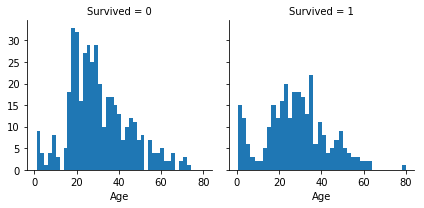

In [8]:
p = seaborn.FacetGrid(train, col="Survived")
p.map(plt.hist, "Age", bins=40)

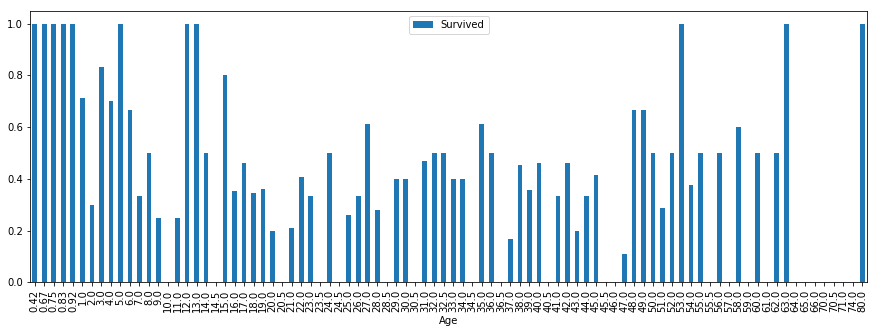

In [9]:
train[["Age", "Survived"]].groupby("Age").mean().plot(kind="bar", figsize=(15, 5))

In [10]:
surv_by_age = train[["Age", "Survived"]].groupby("Age").mean()

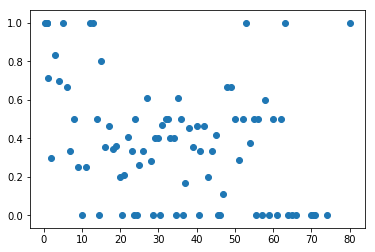

In [11]:
plt.scatter(surv_by_age.index.values, surv_by_age.values)

In [27]:
surv_by_age = surv_by_age.reset_index()

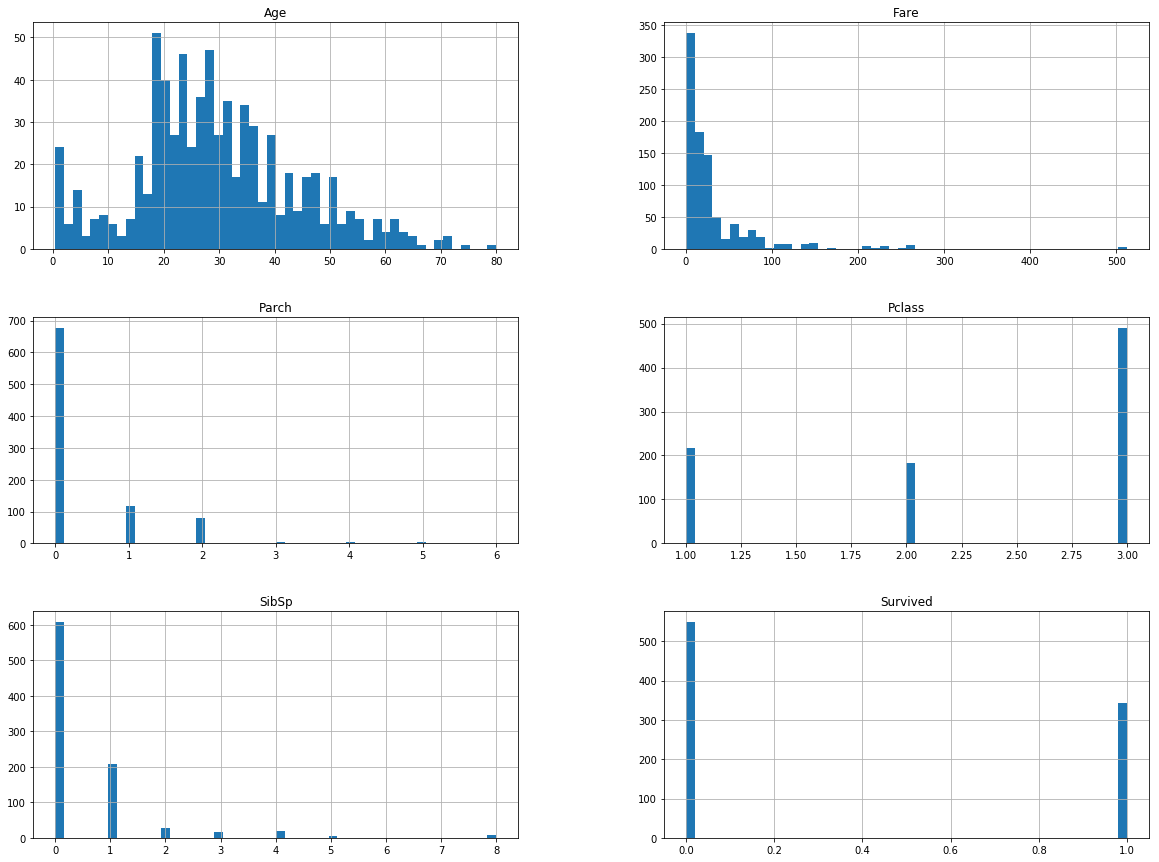

In [35]:
train.hist(bins=50, figsize=(20, 15))
plt.show()

In [37]:
corr_matrix = train.corr()

In [41]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [42]:
corr_matrix["Pclass"].sort_values(ascending=False)

Pclass      1.000000
SibSp       0.083081
Parch       0.018443
Survived   -0.338481
Age        -0.369226
Fare       -0.549500
Name: Pclass, dtype: float64

### The naive approach
Let's just setup a basic pipeline to get a minimal model working. We can then add new or change pieces to improve our model.

#### Prep the data

In [3]:
def make_data(train, drop=None):
    if drop is not None:
        train = train.drop(drop, axis=1).copy()
    train_X = train.drop("Survived", axis=1).copy()
    train_y = train["Survived"].copy()
    return train_X, train_y

In [4]:
train_X, train_y = make_data(train)

#### Make a pipeline

In [5]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.loc[:, self.attribute_names]

In [6]:
class CategoryOneHotImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoded, categories = X.factorize()
        imputer = Imputer(missing_values=-1, strategy="most_frequent")
        imputed = imputer.fit_transform(encoded.reshape(-1, 1)).astype(np.int64)
        one_hotter = OneHotEncoder()
        one_hot = one_hotter.fit_transform(imputed)
        return one_hot

In [7]:
def generate_numerics_pipeline(attribute_names, scaling=False):
    pieces = [
        ('selector', DataFrameSelector(attribute_names)),
        ('imputer', Imputer(strategy="median")),
    ]
    if scaling:
        pieces.append(('std_scaler', StandardScaler()))
    return Pipeline(pieces)

In [8]:
def generate_categories_pipeline(attribute_name):
    return Pipeline([
        ('selector', DataFrameSelector(attribute_name)),
        ('imputer_and_one_hotter', CategoryOneHotImputer()),
    ])

In [65]:
def ordinal_to_one_hot_pipeline(attribute_name):
    return Pipeline([
        ('selector', DataFrameSelector(attribute_name)),
        ('one_hot', OneHotEncoder())
    ])

In [66]:
naive_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", generate_numerics_pipeline(["Parch", "Pclass", "SibSp"])),
    ("num_scale_pipeline", generate_numerics_pipeline(["Age", "Fare"], scaling=True)),
    ("sex_pipeline", generate_categories_pipeline("Sex")),
    ("embarked_pipeline", generate_categories_pipeline("Embarked")),
])
train_X_prep = naive_pipeline.fit_transform(train_X)

In [90]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [12]:
def test_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=10)
    display_scores(scores)

In [84]:
def test_pipeline(pipeline, X_og, y):
    X = pipeline.fit_transform(X_og)
    print("Logistic Regression")
    print("===================")
    test_model(LogisticRegression(), X, y)
    print()
    print("Random Forest")
    print("=============")
    test_model(RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=4), X, y)

#### Test a bunch of different models

In [74]:
test_model(LogisticRegression(), train_X_prep, train_y)

Scores: [0.77777778 0.78888889 0.7752809  0.80898876 0.78651685 0.7752809
 0.78651685 0.78651685 0.82022472 0.82954545]
Mean: 0.7935537963908752
Standard deviation: 0.018253693246381028


In [75]:
test_model(SGDClassifier(max_iter=5, tol=None), train_X_prep, train_y)

Scores: [0.73333333 0.65555556 0.70786517 0.78651685 0.82022472 0.78651685
 0.75280899 0.42696629 0.7752809  0.82954545]
Mean: 0.7274614118715244
Standard deviation: 0.11172141145505768


In [76]:
test_model(LinearSVC(C=1, loss="hinge"), train_X_prep, train_y)

Scores: [0.81111111 0.78888889 0.7752809  0.84269663 0.79775281 0.7752809
 0.76404494 0.74157303 0.80898876 0.76136364]
Mean: 0.7866981613891727
Standard deviation: 0.027942239243488882


In [ ]:
# This takes forever to run
# test_model(SVC(kernel="poly", degree=3, coef0=1, C=5), train_X_prep, train_y)

In [77]:
test_model(SVC(kernel="rbf", gamma=5, C=0.001), train_X_prep, train_y)

Scores: [0.61111111 0.61111111 0.61797753 0.61797753 0.61797753 0.61797753
 0.61797753 0.61797753 0.61797753 0.61363636]
Mean: 0.6161701282487799
Standard deviation: 0.0028367962776526226


In [78]:
test_model(DecisionTreeClassifier(), train_X_prep, train_y)

Scores: [0.7        0.82222222 0.75280899 0.78651685 0.84269663 0.75280899
 0.82022472 0.73033708 0.79775281 0.82954545]
Mean: 0.7834913744183407
Standard deviation: 0.04513004105558957


In [79]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = LinearSVC(C=1, loss="hinge")

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
test_model(voting_clf, train_X_prep, train_y)

Scores: [0.8        0.8        0.78651685 0.84269663 0.82022472 0.76404494
 0.7752809  0.76404494 0.80898876 0.80681818]
Mean: 0.7968615934627171
Standard deviation: 0.0237469834997148


In [80]:
# Can do boostrap=False for Pasting

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=4
)
test_model(bag_clf, train_X_prep, train_y)

Scores: [0.78888889 0.82222222 0.7752809  0.88764045 0.88764045 0.82022472
 0.83146067 0.7752809  0.85393258 0.84090909]
Mean: 0.8283480876177507
Standard deviation: 0.03891786036914392


In [81]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=4)
test_model(rnd_clf, train_X_prep, train_y)

Scores: [0.8        0.83333333 0.76404494 0.91011236 0.86516854 0.80898876
 0.82022472 0.7752809  0.85393258 0.84090909]
Mean: 0.8271995233231187
Standard deviation: 0.041304424940622635


In [82]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
)
test_model(ada_clf, train_X_prep, train_y)

Scores: [0.76666667 0.77777778 0.79775281 0.83146067 0.84269663 0.79775281
 0.82022472 0.83146067 0.83146067 0.84090909]
Mean: 0.813816252411758
Standard deviation: 0.0256535901632698


In [83]:
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=200)
test_model(gb_clf, train_X_prep, train_y)

Scores: [0.8        0.82222222 0.76404494 0.8988764  0.87640449 0.82022472
 0.82022472 0.78651685 0.83146067 0.86363636]
Mean: 0.828361139484735
Standard deviation: 0.03923834294764922


#### Test a bunch of different pipelines

In [87]:
no_scale_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", generate_numerics_pipeline(["Parch", "Pclass", "SibSp", "Age", "Fare"])),
    ("sex_pipeline", generate_categories_pipeline("Sex")),
    ("embarked_pipeline", generate_categories_pipeline("Embarked")),
])
test_pipeline(no_scale_pipeline, train_X, train_y)

Logistic Regression
Scores: [0.77777778 0.78888889 0.7752809  0.85393258 0.78651685 0.7752809
 0.78651685 0.7752809  0.80898876 0.82954545]
Mean: 0.795800987402111
Standard deviation: 0.025495322372601256

Random Forest
Scores: [0.81111111 0.83333333 0.7752809  0.91011236 0.87640449 0.80898876
 0.82022472 0.7752809  0.86516854 0.81818182]
Mean: 0.8294086936783565
Standard deviation: 0.0410337127772736


In [88]:
scale_fare_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", generate_numerics_pipeline(["Parch", "Pclass", "SibSp", "Age"])),
    ("num_scale_pipeline", generate_numerics_pipeline(["Fare"], scaling=True)),
    ("sex_pipeline", generate_categories_pipeline("Sex")),
    ("embarked_pipeline", generate_categories_pipeline("Embarked")),
])
test_pipeline(scale_fare_pipeline, train_X, train_y)

Logistic Regression
Scores: [0.77777778 0.78888889 0.7752809  0.84269663 0.78651685 0.7752809
 0.78651685 0.7752809  0.82022472 0.82954545]
Mean: 0.795800987402111
Standard deviation: 0.023963794592429782

Random Forest
Scores: [0.81111111 0.83333333 0.7752809  0.88764045 0.86516854 0.80898876
 0.82022472 0.7752809  0.86516854 0.82954545]
Mean: 0.8271742707978662
Standard deviation: 0.0355101708353035


In [89]:
scale_both_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", generate_numerics_pipeline(["Parch", "Pclass", "SibSp"])),
    ("num_scale_pipeline", generate_numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("sex_pipeline", generate_categories_pipeline("Sex")),
    ("embarked_pipeline", generate_categories_pipeline("Embarked")),
])
test_pipeline(scale_fare_pipeline, train_X, train_y)

Logistic Regression
Scores: [0.77777778 0.78888889 0.7752809  0.84269663 0.78651685 0.7752809
 0.78651685 0.7752809  0.82022472 0.82954545]
Mean: 0.795800987402111
Standard deviation: 0.023963794592429782

Random Forest
Scores: [0.81111111 0.84444444 0.7752809  0.8988764  0.87640449 0.80898876
 0.82022472 0.7752809  0.86516854 0.82954545]
Mean: 0.8305325729202133
Standard deviation: 0.03901583387931108


In [91]:
more_one_hots = FeatureUnion(transformer_list=[
    ("num_scale_pipeline", generate_numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("ord_to_one_hot", ordinal_to_one_hot_pipeline(["Parch", "Pclass", "SibSp"])),
    ("sex_pipeline", generate_categories_pipeline("Sex")),
    ("embarked_pipeline", generate_categories_pipeline("Embarked")),
])
test_pipeline(more_one_hots, train_X, train_y)

Logistic Regression
Mean: 0.804777267052548
Standard deviation: 0.01890125484307839

Random Forest
Mean: 0.8204826353421859
Standard deviation: 0.043822915362327415
